<a href="https://colab.research.google.com/github/EvgeniaKantor/DI-Bootcamp/blob/main/Exercises_XP_W9D2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mashlyn/online-retail-ii-uci

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci
License(s): CC0-1.0
 34% 5.00M/14.5M [00:00<00:00, 38.5MB/s]
100% 14.5M/14.5M [00:00<00:00, 85.3MB/s]


In [3]:
# Gemini model
!pip install -q -U google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.1/679.1 kB 17.3 MB/s eta 0:00:00


In [4]:
import pathlib
import textwrap
import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [5]:
# Used to securely store your API key
from google.colab import userdata

In [6]:
!unzip online-retail-ii-uci.zip

Archive:  online-retail-ii-uci.zip
  inflating: online_retail_II.csv    


In [7]:
!pip install anthropic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.7/877.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.8 MB/s eta 0:00:00


In [8]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 3.6 MB/s eta 0:00:00


In [9]:
import pandas as pd
import openai
from openai import OpenAI
import os
# import anthropic
import google.generativeai as genai

## Cleane the data

In [10]:
data = pd.read_csv('online_retail_II.csv')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [12]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [13]:
# Convert 'InvoiceDate' to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [14]:
# Deleeating duplicated rows
data.drop_duplicates(inplace=True)
print(data.duplicated().sum())

0


In [15]:
data.isnull().sum()

Invoice             0
StockCode           0
Description      4275
Quantity            0
InvoiceDate         0
Price               0
Customer ID    235151
Country             0
dtype: int64

In [16]:
data = data.dropna(subset=['Customer ID'])
data['Customer ID'] = data['Customer ID'].astype(int)

<ipython-input-16-b7e1fe2327bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Customer ID'] = data['Customer ID'].astype(int)


In [26]:
# Calculate Recency, Frequency, and Monetary values for RFM analysis
# Creates a timestamp for the current date and time
now = pd.Timestamp('now')

# Group by 'Customer ID' and aggregate RFM metrics
rfm = data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (now - x.max()).days,  # Recency: days since last purchase
    'Invoice': 'count',  # Frequency: number of transactions
    'Price': lambda x: (x * data.loc[x.index, 'Quantity']).sum()  # Monetary: total money spent
    })


In [27]:
# Rename columns for clarity
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Price': 'Monetary'
}, inplace=True)

# Define function for scoring and apply it to each RFM metric
def assign_score(x):
    return pd.qcut(x.rank(method='first'), q=4, labels=[4, 3, 2, 1])

rfm['RecencyScore'] = assign_score(rfm['Recency'])
rfm['FrequencyScore'] = assign_score(rfm['Frequency'])
rfm['MonetaryScore'] = assign_score(rfm['Monetary'])

# Calculate the final RFM score
rfm['RFMScore'] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str) + rfm['MonetaryScore'].astype(str)

# Display the first few rows of the RFM dataframe with scores
print(rfm.head())

             Recency  Frequency  Monetary RecencyScore FrequencyScore  \
Customer ID                                                             
12346           4869         47    -51.74            2              3   
12347           4546        222   4921.53            4              1   
12348           4619         51   2019.40            3              3   
12349           4562        180   4404.54            4              1   
12350           4854         17    334.40            2              4   

            MonetaryScore RFMScore  
Customer ID                         
12346                   4      234  
12347                   1      411  
12348                   2      332  
12349                   1      411  
12350                   3      243  


In [28]:
# Define segmentation function
def segment_customer(df):
    if df['RFMScore'] == '444':
        return 'Top Customers'
    elif df['RFMScore'][0] == '4':
        return 'New Customers'
    elif df['RFMScore'][1] == '4':
        return 'Frequent Customers'
    elif df['RFMScore'][2] == '4':
        return 'High-Spending Customers'
    else:
        return 'Others'

# Apply segmentation
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# Display the first few rows of the segmented RFM dataframe
print(rfm.head())

             Recency  Frequency  Monetary RecencyScore FrequencyScore  \
Customer ID                                                             
12346           4869         47    -51.74            2              3   
12347           4546        222   4921.53            4              1   
12348           4619         51   2019.40            3              3   
12349           4562        180   4404.54            4              1   
12350           4854         17    334.40            2              4   

            MonetaryScore RFMScore                  Segment  
Customer ID                                                  
12346                   4      234  High-Spending Customers  
12347                   1      411            New Customers  
12348                   2      332                   Others  
12349                   1      411            New Customers  
12350                   3      243       Frequent Customers  


## Use GEMINI

In [37]:
# Or use `os.getenv('GOOGLE_API_KEY')` to fetch an environment variable.
GOOGLE_API_KEY=userdata.get('gemini_key')

genai.configure(api_key=GOOGLE_API_KEY)


import os
os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY


In [38]:
model = genai.GenerativeModel('gemini-pro')
# Testing Gemini model

response = model.generate_content("From the dataset uploaded in my notebook (online_retail_II.csv) what are the columns title")


In [21]:
to_markdown(response.text)

> ```
> ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
> ```

In [41]:
response = model.generate_content("Calculate RFM (Recency, Frequency, Monetary) scores for each customer in {data} using the 'InvoiceDate', 'Quantity', and 'Price' columns")
to_markdown(response.text)

> ```
> import pandas as pd
> 
> # Read the data 
> df = pd.read_csv('data.csv')
> 
> # Calculate Recency
> df['Recency'] = (df['InvoiceDate'].max() - df['InvoiceDate']).dt.days
> 
> # Calculate Frequency
> df['Frequency'] = df.groupby('CustomerID')['InvoiceDate'].transform('count')
> 
> # Calculate Monetary Value
> df['MonetaryValue'] = df['Quantity'] * df['Price']
> 
> # Calculate RFM Scores
> df['RFM_Score'] = (df['Recency'].rank(pct=True) * 10) + \
>                     (df['Frequency'].rank(pct=True) * 10) + \
>                     (df['MonetaryValue'].rank(pct=True) * 10)
> 
> # Display the results
> print(df[['CustomerID', 'Recency', 'Frequency', 'MonetaryValue', 'RFM_Score']])
> ```

In [42]:
response = model.generate_content(f"Segment customers into groups like ‘High-Value’, ‘Loyal’, or ‘New’ knowing the following data {rfm.head().to_string()}")

to_markdown(response.text)

> - **High-Value Customers**: Customers with high monetary scores, indicating significant spending.
> 
> - **Loyal Customers**: Customers with high frequency scores, indicating frequent purchases.
> 
> - **New Customers**: Customers with low recency scores, indicating recent acquisition.
> 
> - **Frequent Customers**: Customers with high frequency scores, indicating frequent purchases, but may not be high-value.
> 
> - **Others**: Customers who do not fit into any specific segment based on the given criteria.

## Chat GPT

As of my knowledge cutoff date in October 2023, several versions of ChatGPT models have been developed by OpenAI, each with varying sizes and capabilities. These models are part of the broader GPT (Generative Pre-trained Transformer) family. Here is an overview of some key versions:

### GPT-3
- **GPT-3 Models:**
  - **GPT-3 Base / Davinci**
    - The largest and most capable model.
    - Suitable for highly complex tasks, deep text analysis, sophisticated conversational agents, and creative text generation.
  - **GPT-3 Ada, Babbage, Curie**
    - Smaller, more specialized variants with progressively fewer parameters.
    - Ada is the fastest, while Curie is more powerful but slower than Ada and Babbage.

### GPT-4
- **GPT-4**
  - Expected improvements over GPT-3.
  - Enhanced performance in natural language understanding and generation.
  - Integration of more context and better handling of nuanced language.

### GPT-3.5 (Codex)
- **Codex (part of GPT-3.5)**
  - Specialized for code understanding and generation.
  - Powers tools like GitHub Copilot.

### GPT-2
- **GPT-2 Models:**
  - **GPT-2 Small**
    - Contains fewer parameters and offers faster performance with lower computational requirements.
    - Suitable for simple text generation, basic dialogue systems, and lightweight applications.
  - **GPT-2 Medium, Large, and XL**
    - Progressively larger models with more parameters, offering better understanding and generation capabilities.
    - Suitable for more complex text analysis and applications requiring more nuanced language handling.

### GPT-1
- **GPT-1**
  - The original model that introduced the Transformer architecture for pre-trained language models.
  - Less capable compared to its successors but still useful for understanding the fundamental capabilities of GPT models in text generation and basic NLP tasks.

### Specialized Models
- **Codex** (Part of GPT-3.5 series)
  - Tailored for understanding and generating programming code.
  - Powers applications like GitHub Copilot, aiding in software development by interpreting, generating, and completing code.

### Summary
- For general text-based analysis and natural language tasks, GPT-3 (Davinci) or GPT-4 models are highly recommended due to their advanced capabilities



In [45]:
df_string = data.head(10).to_string(index=False)

In [58]:
import openai
import os

# Retrieve your API key from userdata or any other source
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# Set the API key in the environment
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

# Initialize the OpenAI client
client = Client()


In [64]:
def get_rfm_guidance(data):
    df_string = data.head().to_string()  # Convert a small part of dataframe to string for context

    # Request RFM calculation guidance from OpenAI
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a data analyst."},
            {"role": "user", "content": f"Calculate RFM (Recency, Frequency, Monetary) scores for each customer in this dataset using the 'InvoiceDate', 'Quantity', and 'Price' columns in my notebook (online_retail_II.csv). Here is a sample of the data:\n{df_string}"}
        ]
    )

    return response.choices[0].message

guidance = get_rfm_guidance(data)
guidance

ChatCompletionMessage(content="To calculate RFM scores for each customer in the dataset, we first need to determine recency, frequency, and monetary values for each customer based on their purchase history. Recency represents how recently a customer made a purchase, frequency represents how often a customer makes purchases, and monetary represents how much a customer spends.\n\nHere is the Python code that calculates RFM scores for each customer using the given dataset:\n\n```python\nimport pandas as pd\n\n# Load the data\ndata = pd.read_csv('online_retail_II.csv')\n\n# Make sure the 'InvoiceDate' column is in datetime format\ndata['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])\n\n# Calculate 'Recency', which is the number of days since the last purchase for each customer\ndata['Recency'] = (data['InvoiceDate'].max() - data['InvoiceDate']).dt.days\n\n# Calculate 'Frequency', which is the total number of purchases made by each customer\nfrequency = data.groupby('Customer ID')['Inv

In [65]:
def get_rfm_guidance(data):
    df_string = data.head().to_string()  # Convert a small part of dataframe to string for context

    # Request RFM calculation guidance from OpenAI
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a data analyst."},
            {"role": "user", "content": f"Segment customers into groups like ‘High-Value’, ‘Loyal’, or ‘New’ knowing the data {df_string}"}
        ]
    )

    return response.choices[0].message

guidance = get_rfm_guidance(data)
guidance

ChatCompletionMessage(content="To segment customers into groups like 'High-Value', 'Loyal', or 'New', we can follow these steps using the provided data:\n\n1. **Calculate RFM Metrics**:\n    - Recency: How recently a customer has made a purchase (based on the latest InvoiceDate).\n    - Frequency: How often a customer makes a purchase (based on the number of unique invoices).\n    - Monetary: How much money a customer spends with the company (based on total Price).\n\n2. **Assign Segment Criteria**:\n    - High-Value Customers: Customers who have high RFM scores, indicating recent purchases, frequent buying, and high spending.\n    - Loyal Customers: Customers who have high Frequency and Recency scores, indicating they are loyal and active.\n    - New Customers: Customers with low Frequency but high Recency, they may need nurturing to become loyal.\n\n3. **Segment Customers**:\n    - We can use RFM scores to segment customers into the defined groups.\n    - We can also consider additio

## Exercise 2

Using ChatGPT for such tasks would be more relevant for text-based anonymization. For structured data like Customer ID and Country, hashing is more efficient and straightforward.

Check for Re-Identification Risks: Ensure that the anonymized data cannot be easily reversed or linked back to individuals.

In [66]:
def get_rfm_guidance(data):
    df_string = data.head().to_string()  # Convert a small part of dataframe to string for context

    # Request RFM calculation guidance from OpenAI
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a data analyst."},
            {"role": "user", "content": f"Generate anonymized data for these personal identifiers in the dataframe {df_string} or use a hashing function"}
        ]
    )

    return response.choices[0].message

guidance = get_rfm_guidance(data)
guidance

ChatCompletionMessage(content='To anonymize the personal identifier Customer ID in the dataframe, we can use a hashing function like SHA-256 to transform the original IDs into anonymized hashed values. Here\'s an example code snippet using Python and the Pandas library to generate anonymized data for the given dataframe:\n\n```python\nimport pandas as pd\nimport hashlib\n\n# Sample data\ndata = {\n    \'Invoice\': [489434, 489434, 489434, 489434, 489434],\n    \'StockCode\': [85048, 79323P, 79323W, 22041, 21232],\n    \'Description\': [\'15CM CHRISTMAS GLASS BALL 20 LIGHTS\', \'PINK CHERRY LIGHTS\', \'WHITE CHERRY LIGHTS\', \'RECORD FRAME 7" SINGLE SIZE\', \'STRAWBERRY CERAMIC TRINKET BOX\'],\n    \'Quantity\': [12, 12, 12, 48, 24],\n    \'InvoiceDate\': [\'2009-12-01 07:45:00\', \'2009-12-01 07:45:00\', \'2009-12-01 07:45:00\', \'2009-12-01 07:45:00\', \'2009-12-01 07:45:00\'],\n    \'Price\': [6.95, 6.75, 6.75, 2.10, 1.25],\n    \'Customer ID\': [13085, 13085, 13085, 13085, 13085],\n

In [67]:
import hashlib

# Function to hash personal data
def hash_data(value):
    return hashlib.sha256(value.encode()).hexdigest()

# Apply the hashing function to 'Customer ID' and 'Country'
data['Customer ID'] = data['Customer ID'].apply(lambda x: hash_data(str(x)) if not pd.isnull(x) else x)
data['Country'] = data['Country'].apply(lambda x: hash_data(str(x)))

# Display the first few rows of the anonymized dataset
print(data.head())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  \
0 2009-12-01 07:45:00   6.95   
1 2009-12-01 07:45:00   6.75   
2 2009-12-01 07:45:00   6.75   
3 2009-12-01 07:45:00   2.10   
4 2009-12-01 07:45:00   1.25   

                                         Customer ID  \
0  0e399ff37c2c973d9036a0262f6e5919f8ac2c81905ceb...   
1  0e399ff37c2c973d9036a0262f6e5919f8ac2c81905ceb...   
2  0e399ff37c2c973d9036a0262f6e5919f8ac2c81905ceb...   
3  0e399ff37c2c973d9036a0262f6e5919f8ac2c81905ceb...   
4  0e399ff37c2c973d9036a0262f6e5919f8ac2c81905ceb...   

                                             Coun

## Exercise 3

In [68]:
# Create a new column for total sales
data['TotalPrice'] = data['Quantity'] * data['Price']

# Aggregate the data on a monthly basis
monthly_data = data.resample('M', on='InvoiceDate').agg({'TotalPrice': 'sum', 'Quantity': 'sum'}).reset_index()

# Display the aggregated data
print(monthly_data.head())

  InvoiceDate  TotalPrice  Quantity
0  2009-12-31  660125.100    388795
1  2010-01-31  530436.512    366302
2  2010-02-28  487596.426    365418
3  2010-03-31  633419.311    497681
4  2010-04-30  558007.832    344152


In [70]:
def get_insights_from_chatgpt(data, query):
    # Convert a small part of dataframe to string for context
    df_string = data.head().to_string()

    # Request insight from OpenAI
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a data analyst."},
            {"role": "user", "content": f"Given this dataset:\n{df_string}\n\n{query}"}
        ]
    )

    return response.choices[0].message

# List of queries for analysis
queries = [
    "What are the overall sales trends over the months?",
    "Which months show the highest and lowest sales?",
    "Is there any seasonality in the sales data?",
    "What are the average monthly sales and quantities sold?"
]

# Get insights for each query
for query in queries:
    insights = get_insights_from_chatgpt(data, query)
    print(f"Query: {query}\nInsight: {insights}\n")


Query: What are the overall sales trends over the months?
Insight: ChatCompletionMessage(content='To analyze the overall sales trends over the months, we can follow these steps:\n\n1. Extract the month and year from the \'InvoiceDate\' column.\n2. Group the data by month and calculate the total sales (TotalPrice) for each month.\n3. Visualize the sales trends using a line plot.\n\nHere is the Python code to achieve this:\n\n```python\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the dataset\ndata = {\n    \'Invoice\': [489434, 489434, 489434, 489434, 489434],\n    \'StockCode\': [85048, 79323P, 79323W, 22041, 21232],\n    \'Description\': [\'15CM CHRISTMAS GLASS BALL 20 LIGHTS\', \'PINK CHERRY LIGHTS\', \'WHITE CHERRY LIGHTS\',\n                    \'RECORD FRAME 7" SINGLE SIZE\', \'STRAWBERRY CERAMIC TRINKET BOX\'],\n    \'Quantity\': [12, 12, 12, 48, 24],\n    \'InvoiceDate\': [\'2009-12-01 07:45:00\', \'2009-12-01 07:45:00\', \'2009-12-01 07:45:00\', \n            

In [71]:
# Sample Data for Context
df_string = data.head().to_string()

# Queries and Insights
queries = [
    "What are the overall sales trends over the months?",
    "Which months show the highest and lowest sales?",
    "Is there any seasonality in the sales data?",
    "What are the average monthly sales and quantities sold?"
]

# Fetch insights for each query
for query in queries:
    insights = get_insights_from_chatgpt(data, query)
    print(f"Query: {query}\nInsight: {insights}\n")


Query: What are the overall sales trends over the months?
Insight: ChatCompletionMessage(content='To analyze the overall sales trends over the months, we can aggregate the TotalPrice column by month. Here\'s a step-by-step guide on how to do this using Python and pandas:\n\n1. First, import the necessary libraries:\n```python\nimport pandas as pd\nimport matplotlib.pyplot as plt\n```\n\n2. Next, read the dataset and ensure the "InvoiceDate" column is in datetime format:\n```python\ndata = pd.read_csv(\'your_dataset.csv\')\ndata[\'InvoiceDate\'] = pd.to_datetime(data[\'InvoiceDate\'])\n```\n\n3. Create a new column for extracting the month from the "InvoiceDate":\n```python\ndata[\'InvoiceMonth\'] = data[\'InvoiceDate\'].dt.to_period(\'M\')\n```\n\n4. Group the data by "InvoiceMonth" and calculate the total sales for each month:\n```python\nmonthly_sales = data.groupby(\'InvoiceMonth\')[\'TotalPrice\'].sum()\n```\n\n5. Plot the monthly sales trends using a line plot:\n```python\nplt.fig

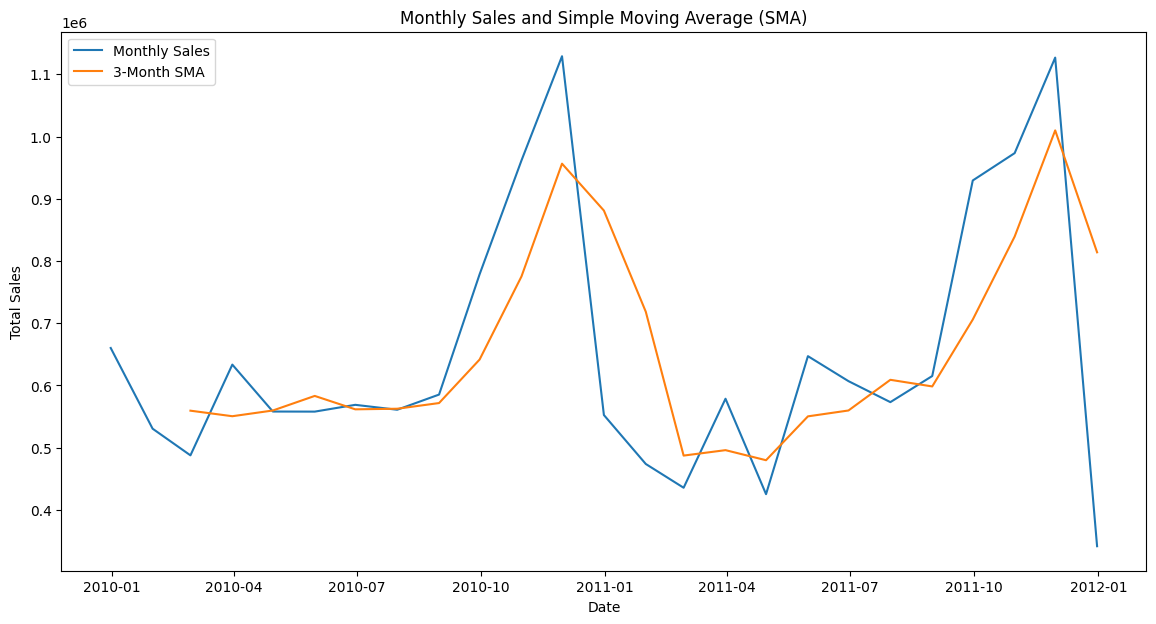

Forecasted Sales for the Next Quarter: [813892.9600000001, 813892.9600000001, 813892.9600000001]


In [73]:
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate the Simple Moving Average (SMA) for the last 3 months
monthly_data['SMA'] = monthly_data['TotalPrice'].rolling(window=3).mean()

# Plot the monthly sales data with SMA
plt.figure(figsize=(14, 7))
sns.lineplot(x='InvoiceDate', y='TotalPrice', data=monthly_data, label='Monthly Sales')
sns.lineplot(x='InvoiceDate', y='SMA', data=monthly_data, label='3-Month SMA')
plt.title('Monthly Sales and Simple Moving Average (SMA)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

# Forecast sales for the next quarter (simple extrapolation of the last SMA)
last_sma = monthly_data['SMA'].iloc[-1]
forecasted_sales = [last_sma] * 3
print(f"Forecasted Sales for the Next Quarter: {forecasted_sales}")


Discussion

ChatGPT-Assisted Analysis vs. Traditional Methods:

Efficiency: ChatGPT can quickly summarize trends, reducing the time spent on manual data exploration.
Interpretation: ChatGPT can provide detailed explanations and highlight trends that might be missed in a manual analysis.
Automation: Automating queries and analyses can save significant time and ensure consistency.
Potential of AI in Data Analysis:

Accuracy: AI models can identify subtle patterns and trends, improving the accuracy of insights and predictions.
Scalability: AI can handle large datasets efficiently, making it suitable for analyzing big data.
Insight Generation: AI can generate actionable insights and recommendations, aiding in strategic decision-making.
Limitations of SMA
Lagging Indicator: SMA is a lagging indicator and may not accurately reflect recent changes in sales trends.
Simplicity: SMA does not account for seasonality or other complex patterns, limiting its effectiveness for long-term forecasts.